# Modelos FLUX

O modelo FLUX possibilita gerar imagens de altíssima qualidade. O modelo possui 12 bilhões de parâmetros e necessita de GPUs com 32GB de memória VRAM, mas pode ser executado em GPUs com 24GB de forma "confortável". No exemplo abaixo é usado quantização e offload de CPU, o que possibilita rodar o modelo em placas com 10GB de VRAM. Note que é necessária uma boa quantidade de RAM (não VRAM) para manter o modelo.

Os principais modelos da fámilia FLUX são:

| Modelo | Aplicação |
|:----------:|:--------:|
| [`black-forest-labs/FLUX.1-dev`](https://huggingface.co/black-forest-labs/FLUX.1-dev) | Melhor qualidade | 
| [`black-forest-labs/FLUX.1-schnell`](https://huggingface.co/black-forest-labs/FLUX.1-schnell) | Geração rápida | 
| [`black-forest-labs/FLUX.1-kontext`](https://huggingface.co/black-forest-labs/FLUX.1-Kontext-dev) | Alteração de imagens | 
| [`black-forest-labs/FLUX.1-Fill-dev`](https://huggingface.co/black-forest-labs/FLUX.1-Fill-dev) | Inpainting de regiões | 
| [`black-forest-labs/FLUX.1-Canny-dev`](https://huggingface.co/black-forest-labs/FLUX.1-Canny-dev) | Geração usando contornos | 
| [`black-forest-labs/FLUX.1-Depth-dev`](https://huggingface.co/black-forest-labs/FLUX.1-Depth-dev) | Geração usando profundidade | 
| [`black-forest-labs/FLUX.1-Canny-dev-lora`](https://huggingface.co/black-forest-labs/FLUX.1-Canny-dev-lora) | Geração com contorno (LoRA) | 
| [`black-forest-labs/FLUX.1-Depth-dev-lora`](https://huggingface.co/black-forest-labs/FLUX.1-Depth-dev-lora) | Geração com profundidade (LoRA) | 

### Inicialização do modelo

In [ ]:
import torch

from diffusers import FlowMatchEulerDiscreteScheduler, AutoencoderKL
from diffusers.models.transformers.transformer_flux import FluxTransformer2DModel
from diffusers.pipelines.flux.pipeline_flux import FluxPipeline
from transformers import CLIPTextModel, CLIPTokenizer,T5EncoderModel, T5TokenizerFast, BitsAndBytesConfig

dtype = torch.bfloat16

quantization_config = BitsAndBytesConfig(
    load_in_bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=dtype
)

# black-forest-labs/FLUX.1-schnell   # Para geração rápida com qualidade um pouco menor que o dev
bfl_repo = "black-forest-labs/FLUX.1-dev"

# É possível inicializar o modelo de forma bem mais simples, mas como precisamos quantizar partes
# do modelo, é necessário carregar os componentes separadamente.
# Note que quantizamos o modelo `text_encoder_2` e o modelo `transformer`
scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(bfl_repo, subfolder="scheduler")
text_encoder = CLIPTextModel.from_pretrained(bfl_repo, subfolder="text_encoder", torch_dtype=dtype)
tokenizer = CLIPTokenizer.from_pretrained(bfl_repo, subfolder="tokenizer", torch_dtype=dtype)
text_encoder_2 = T5EncoderModel.from_pretrained(bfl_repo, subfolder="text_encoder_2", quantization_config=quantization_config, torch_dtype=dtype).to("cpu")
tokenizer_2 = T5TokenizerFast.from_pretrained(bfl_repo, subfolder="tokenizer_2", torch_dtype=dtype)
vae = AutoencoderKL.from_pretrained(bfl_repo, subfolder="vae", torch_dtype=dtype)
transformer = FluxTransformer2DModel.from_pretrained(bfl_repo, subfolder="transformer", quantization_config=quantization_config, torch_dtype=dtype).to("cpu")

pipe = FluxPipeline(
    scheduler=scheduler,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    text_encoder_2=text_encoder_2,
    tokenizer_2=tokenizer_2,
    vae=vae,
    transformer=transformer,
)

# Habilita o uso de CPU offloading. As partes do modelo são mantidas na RAM da CPU, e movidas
# para a GPU apenas quando necessário. Isso reduz o uso de VRAM, mas aumenta o tempo de inferência.
pipe.enable_model_cpu_offload()

### Geração das imagens

In [ ]:
# Prompts gerados pelo Gemini!
prompts = [
    "A dramatic wide-angle landscape photograph of the Scottish Highlands after a storm. Dark, heavy clouds are breaking apart to reveal epic sunrays lighting up a green valley and a lone, winding road. Majestic, awe-inspiring, shot with a high-resolution DSLR, sharp details, polarizer filter effect on the sky.",
    "An ultra-realistic photo of the overgrown, abandoned interior of a grand ballroom. Sunlight streams through a broken arched window, illuminating dust particles floating in the air and casting long shadows across decaying furniture and peeling wallpaper. Eerie, beautiful decay, high dynamic range (HDR).",
    "A top-down, flat-lay photo of a rustic wooden table with a half-eaten croissant, a steaming cup of black coffee in a ceramic mug, and a scattered handful of fresh blueberries. Soft, natural window light from the side. Cozy, Sunday morning atmosphere, shot on Kodak Gold 200 film.",
    "A macro photograph of a single perfect raspberry falling into a glass of sparkling champagne. The focus is razor-sharp on the bubbles fizzing around the fruit. Bright, clean, high-key lighting against a minimalist white background. Commercial product photography style, extremely detailed.",
    "An extreme close-up of the weathered keys of a 1980s mechanical keyboard on a cluttered desk. The keys have a slight yellow patina, and you can see dust and fingerprints under the focused, cinematic lighting. Shallow depth of field, with vintage computer monitors blurred in the background. Nostalgic, hyper-detailed.",
]

for idx, prompt in enumerate(prompts):

    image = pipe(
        prompt,
        height=1024,
        width=1024,
        guidance_scale=3.5,
        num_inference_steps=50,
        max_sequence_length=512,        # Evita que o prompt seja truncado em 77 tokens
        generator=torch.Generator().manual_seed(0)
    ).images[0]

    image.save(f"../data/generated_images/image_{idx}.jpg")

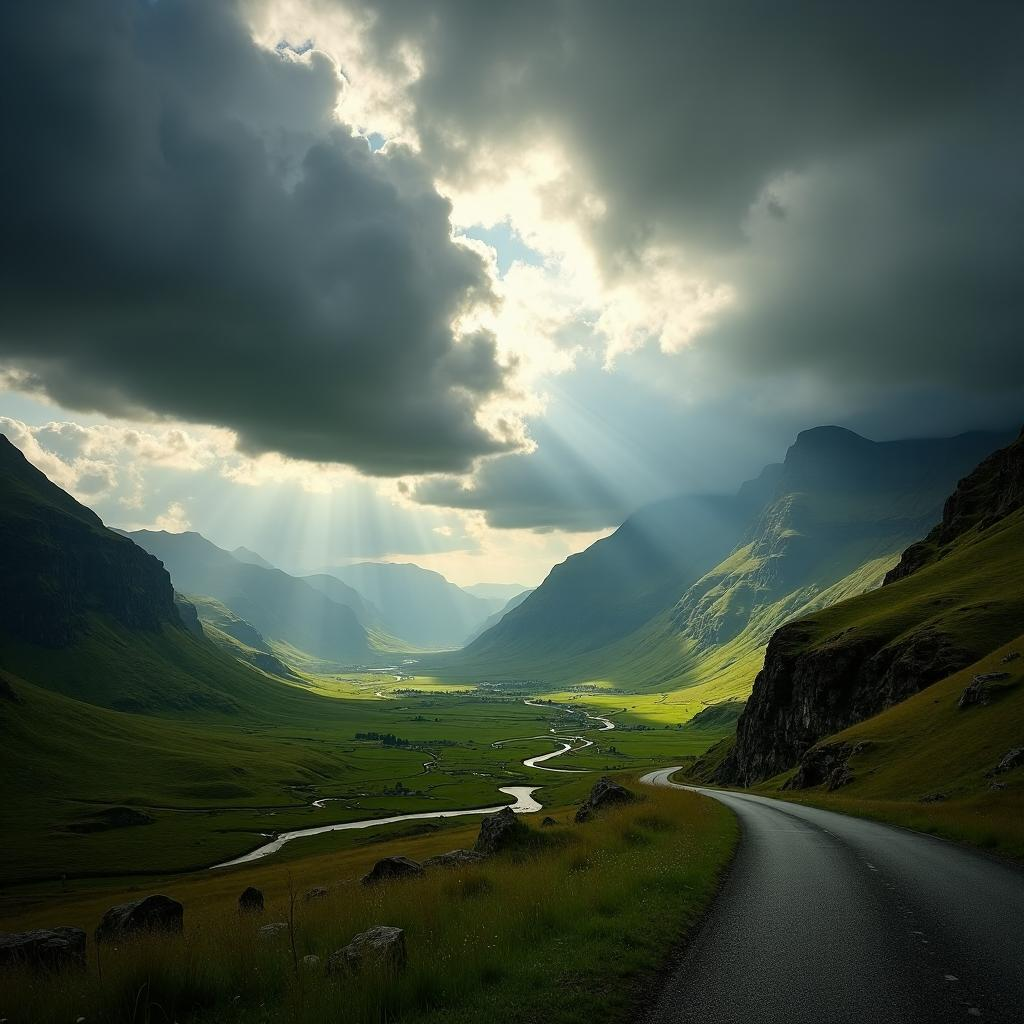

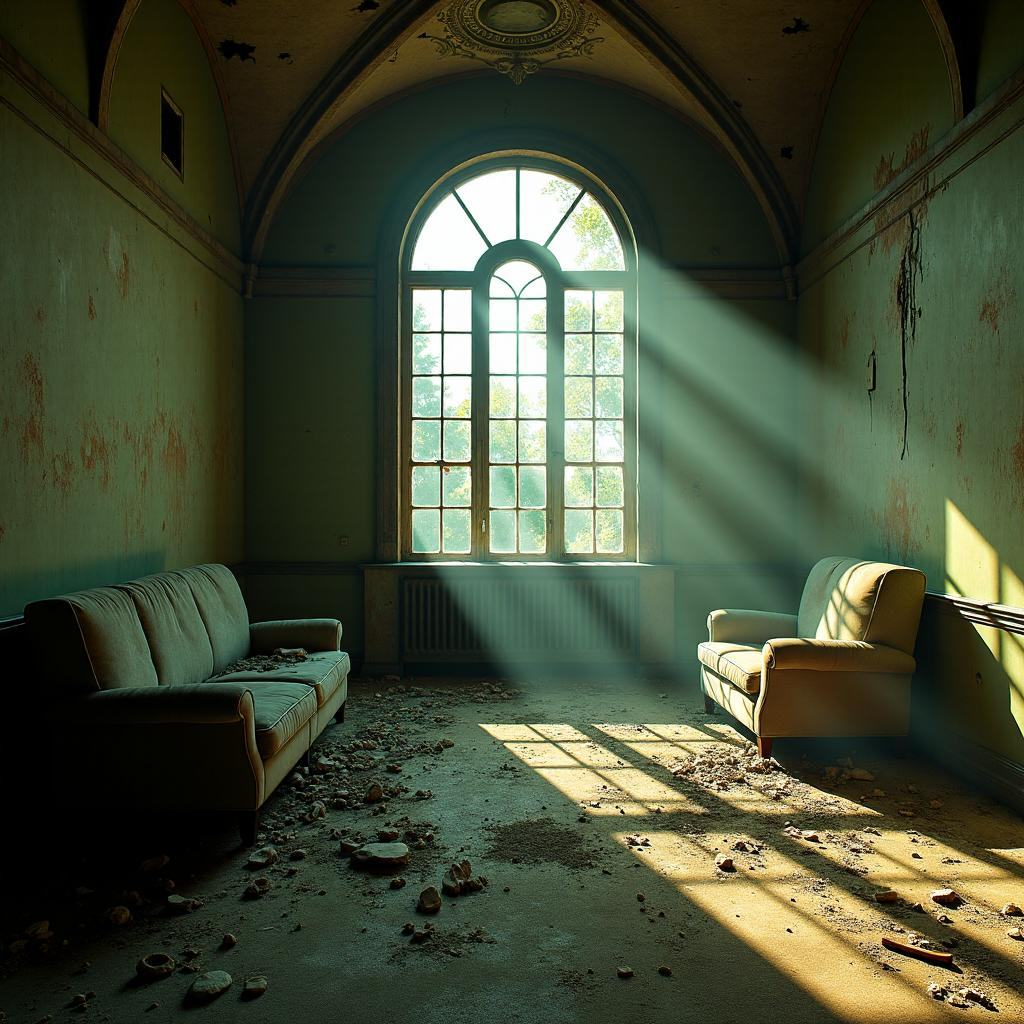

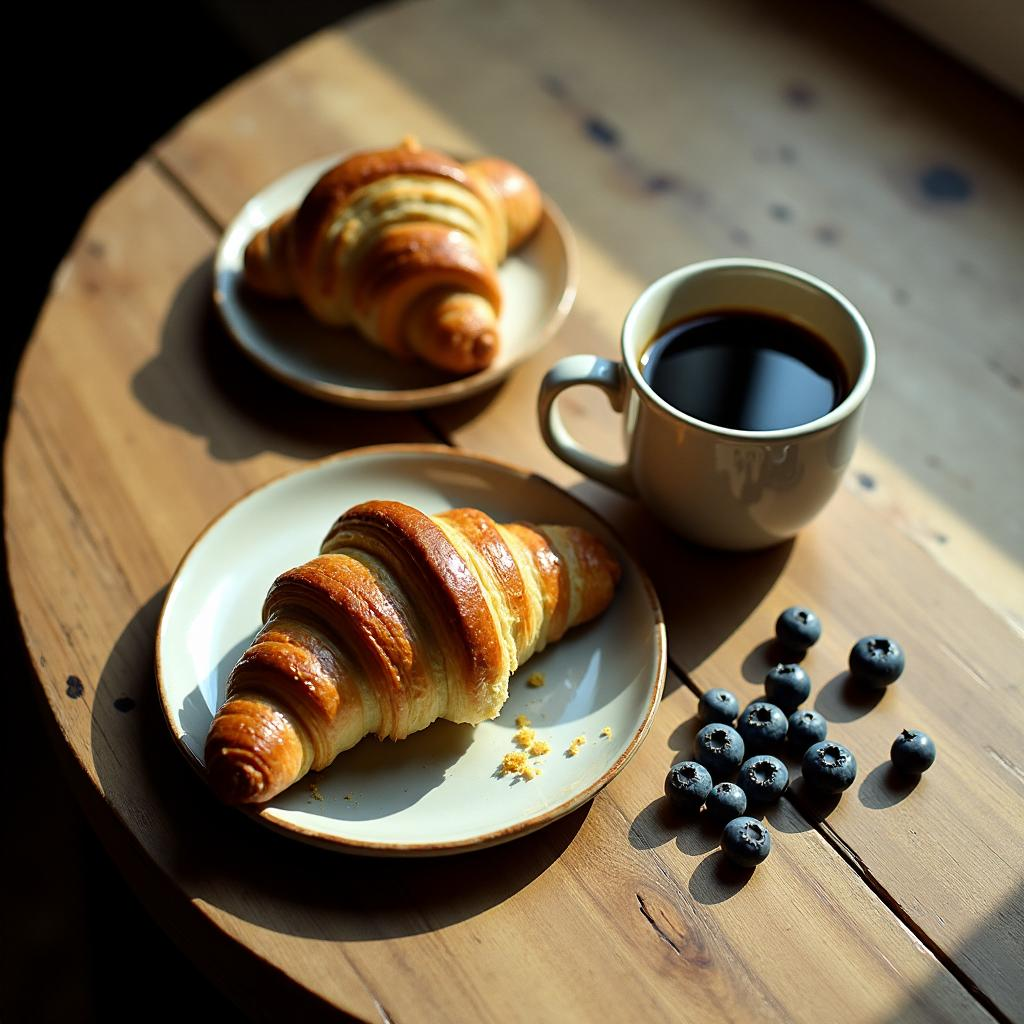

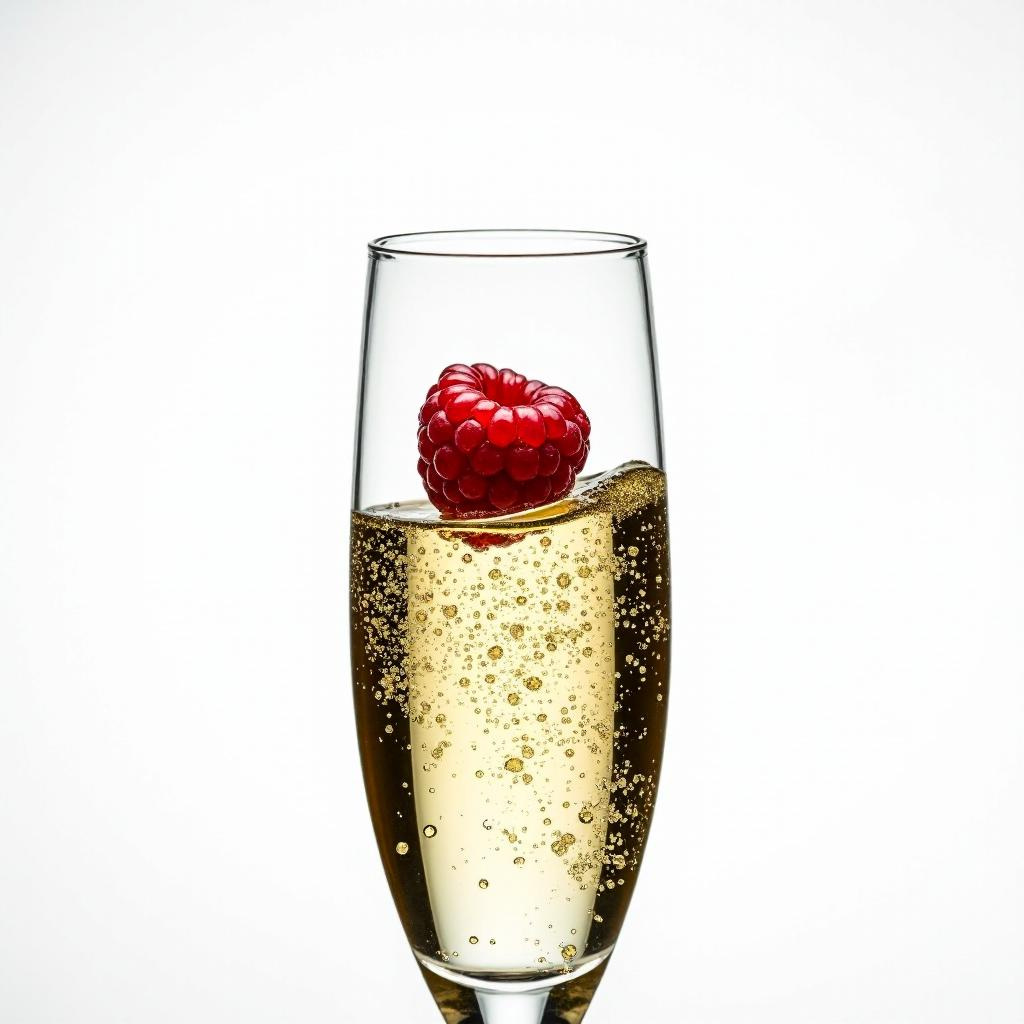

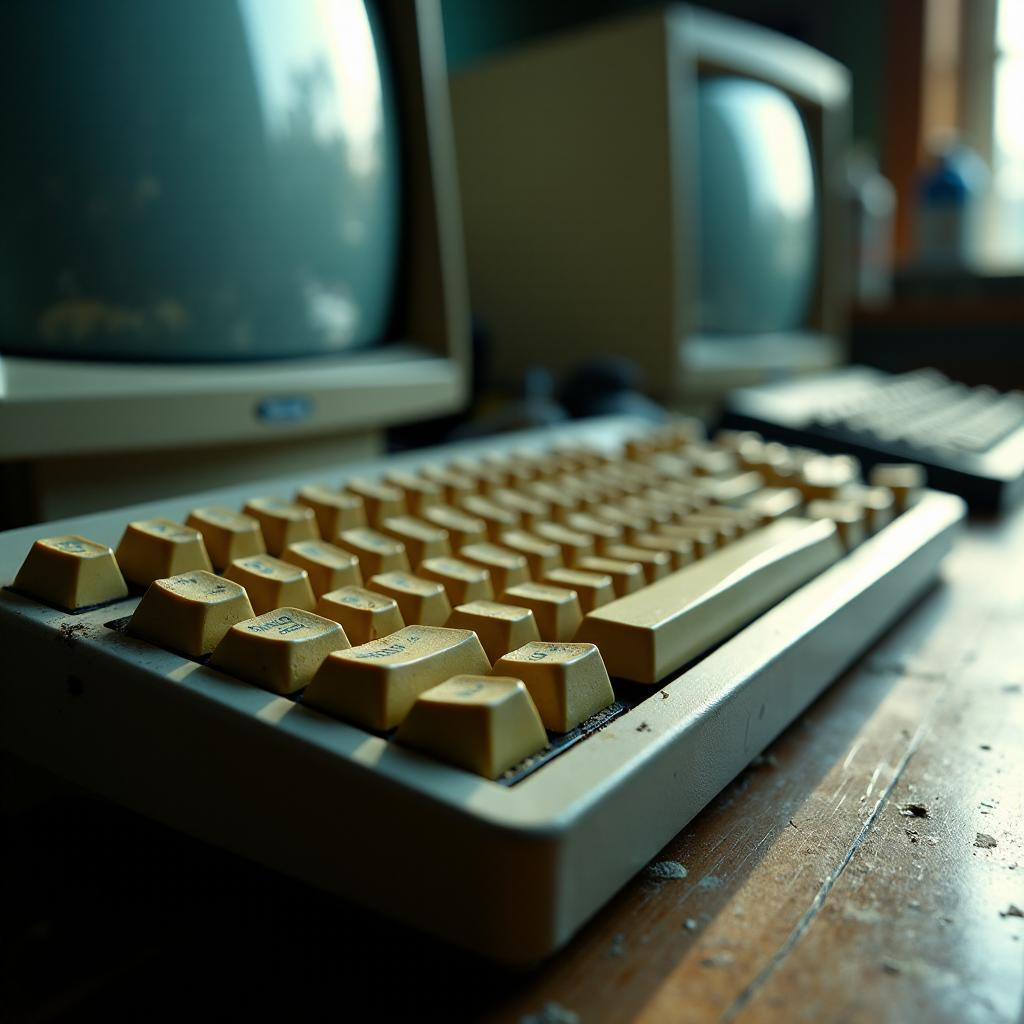

In [3]:
from IPython.display import Image, display

# As imagens geradas são exibidas no formato jpg usando IPython para reduz o tamanho do notebook.
for idx in range(5):
    display(Image(filename=f"../data/generated_images/image_{idx}.jpg"))

### FLUX Kontext

O modelo Kontext permite editar imagens. O modelo foi adicionado ao Hugginface em 26/06/2025, portanto é preciso a versão mais recente da biblitoeca para usá-lo.

In [ ]:
import torch

from diffusers import FlowMatchEulerDiscreteScheduler, AutoencoderKL
from diffusers.models.transformers.transformer_flux import FluxTransformer2DModel
from diffusers.pipelines.flux.pipeline_flux_kontext import FluxKontextPipeline
from transformers import CLIPTextModel, CLIPTokenizer,T5EncoderModel, T5TokenizerFast, BitsAndBytesConfig

dtype = torch.bfloat16

quantization_config = BitsAndBytesConfig(
    load_in_bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=dtype
)

bfl_repo = "black-forest-labs/FLUX.1-Kontext-dev"

scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(bfl_repo, subfolder="scheduler")
text_encoder = CLIPTextModel.from_pretrained(bfl_repo, subfolder="text_encoder", torch_dtype=dtype)
tokenizer = CLIPTokenizer.from_pretrained(bfl_repo, subfolder="tokenizer", torch_dtype=dtype)
text_encoder_2 = T5EncoderModel.from_pretrained(bfl_repo, subfolder="text_encoder_2", quantization_config=quantization_config, torch_dtype=dtype).to("cpu")
tokenizer_2 = T5TokenizerFast.from_pretrained(bfl_repo, subfolder="tokenizer_2", torch_dtype=dtype)
vae = AutoencoderKL.from_pretrained(bfl_repo, subfolder="vae", torch_dtype=dtype)
transformer = FluxTransformer2DModel.from_pretrained(bfl_repo, subfolder="transformer", quantization_config=quantization_config, torch_dtype=dtype).to("cpu")

pipe = FluxKontextPipeline(
    scheduler=scheduler,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    text_encoder_2=text_encoder_2,
    tokenizer_2=tokenizer_2,
    vae=vae,
    transformer=transformer,
)

pipe.enable_model_cpu_offload()

  0%|          | 0/28 [00:00<?, ?it/s]

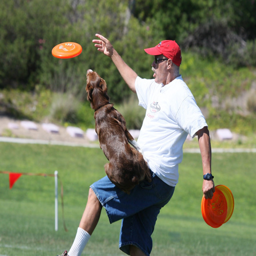

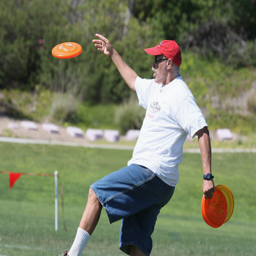

In [2]:
from PIL import Image

image = Image.open("../data/man_with_dog.jpg").resize((512, 512))

new_image = pipe(
    image=image,
    prompt="Remove the dog from the image",
    guidance_scale=2.5,
    #num_inference_steps=50,
    generator=torch.Generator().manual_seed(0)
).images[0]

display(image.resize((256, 256)), new_image.resize((256, 256)))

  0%|          | 0/28 [00:00<?, ?it/s]

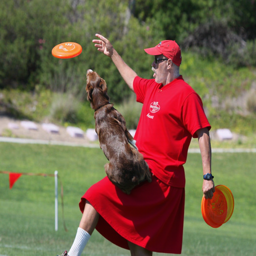

In [3]:
new_image = pipe(
    image=image,
    prompt="Change the man's clothes to a red dress",
    guidance_scale=2.5,
    #num_inference_steps=50,
    generator=torch.Generator().manual_seed(0)
).images[0]

display(new_image.resize((256, 256)))

  0%|          | 0/28 [00:00<?, ?it/s]

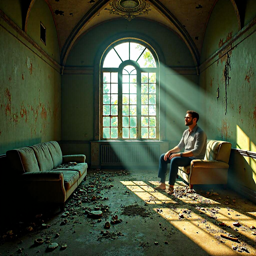

In [4]:
image = Image.open("../data/generated_images/image_1.jpg")

new_image = pipe(
    image=image,
    prompt="Add a man sitting at the chair",
    guidance_scale=2.5,
    generator=torch.Generator().manual_seed(0)
).images[0]

display(new_image.resize((256, 256)))

### Para saber mais

A documentação da biblioteca diffusers possui diversos exemplos sobre o uso de modelos de difusão. No link

https://huggingface.co/docs/diffusers/quicktour#diffusionpipeline

há uma tabela com as principais tarefas de geração de imagens que podem ser realizadas com a biblioteca: geração incondicional, geração condicionada em texto, geração condicionada em outra imagem e inpainting (remoção de objetos ou artefatos de imagens). 

Por exemplo, há [instruções para geração de imagens a partir de texto](https://huggingface.co/docs/diffusers/using-diffusers/conditional_image_generation) e também [exemplos de geração usando o modelo SDXL](https://huggingface.co/docs/diffusers/using-diffusers/sdxl)

A biblioteca também possui uma documentação sobre procedimentos que podem ser utilizados para refinar um modelo em imagens específicas. Por exemplo, a técnica [textual inversion](https://huggingface.co/docs/diffusers/training/text_inversion) permite refinar um modelo de geração em cerca de 5 imagens de um objeto específico e gerar novas imagens com esse objeto.

